## Proyecto 1 - Aprendizaje Automático
### Integrantes:
- A. Badilla Olivas B80874
- Enrique Vilchez Lizano C18477
- Brandon Mora Umaña 
- Joseph Valverde Kong C18100

In [1]:
# Import necessary modules
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Data handling
import pandas as pd

# Preprocessing tools
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler

# Model selection tools
from model_selection_and_training import *

# Plots
import matplotlib.pyplot as plt
from plot_functions import *

# Wine Quality Dataset

## Dataset Preparation

In [2]:
# read and explore the dataset
wine_data = pd.read_csv("datasets/winequality_red.csv")

In [3]:
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [5]:
wine_data.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


In [6]:
# Remove rows with empty data on the label
wine_data.dropna(axis=0, subset=["quality"], inplace=True)

# Separate data
y_wine = wine_data["quality"]
X_wine = wine_data.drop(columns=["quality"])
X_wine.describe()

# Modify quality labels to 1 or 0
y_wine = y_wine.apply(lambda x: 1 if x > 6 else 0)
y_wine.value_counts()

# Scale the data
normalizer = StandardScaler()
X_wine_normalized = pd.DataFrame(normalizer.fit_transform(X_wine))

# After we transform the data, we should put back the column names
X_wine_normalized.columns = X_wine.columns.astype(str)

## Logistic Regression

In [7]:
# Parameters selection
search_space_log = {
    "fit_intercept": [True, False],  # Add bias constant or not
    "solver": ["lbfgs", "liblinear", "newton-cholesky", "newton-cg", "sag", "saga"],
    "max_iter": [1, 5, 10, 30, 50, 100],
}

log_classifier = LogisticRegression(random_state=1)
best_log_score, best_log_params, results_log = make_grid_search(
    model=log_classifier, search_space=search_space_log, X=X_wine_normalized, Y=y_wine
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [8]:
print("Tuned hyperparameters (best parameters): ", best_log_params)
print("Best score:", best_log_score)

Tuned hyperparameters (best parameters):  {'fit_intercept': True, 'max_iter': 1, 'solver': 'sag'}
Best score: 0.8835019173273363


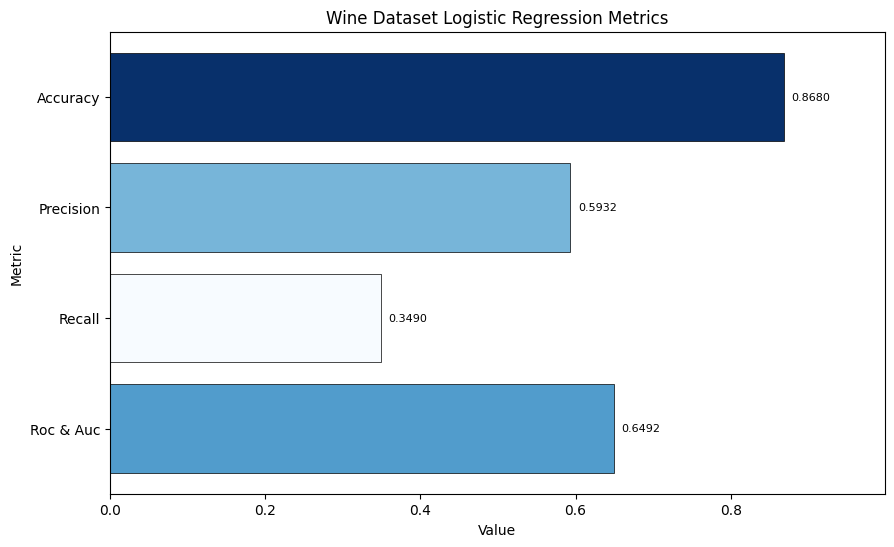

In [9]:
log_classifier = LogisticRegression(random_state=1, **best_log_params)
algorithm_name = "Logistic Regression"
log_metrics, confusion_mat = fit_and_get_metrics(
    model=log_classifier,
    algorithm=algorithm_name,
    X=X_wine_normalized,
    Y=y_wine,
    n_folds=5,
)
plot_barplot_model_metrics(
    metrics=log_metrics,
    algorithm=algorithm_name,
    title="Wine Dataset Logistic Regression Metrics",
    color=plt.cm.Blues,
)

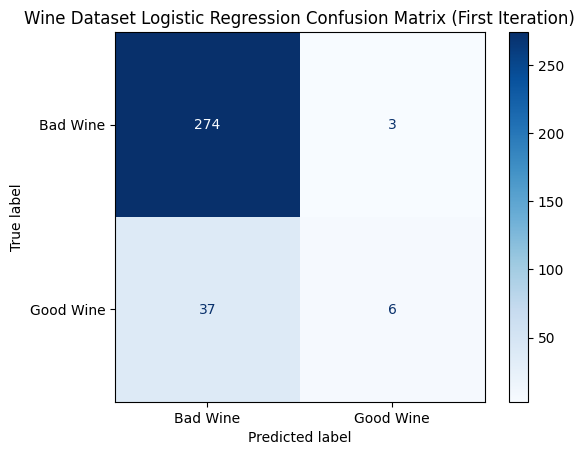

In [10]:
plot_confusion_matrix(
    confusion_matrix=confusion_mat,
    labels=["Bad Wine", "Good Wine"],
    title="Wine Dataset Logistic Regression Confusion Matrix (First Iteration)",
    colors=plt.cm.Blues,
)

## Decision Trees

In [11]:
# Parameters selection
search_space_tree = {
    "criterion": ["gini", "entropy", "log_loss"],  # Loss criteria
    "splitter": ["best", "random"],  # Type of split for the nodes
    "max_depth": [1, 5, 10, 30, 50, 100],  # Maxiumun tree depth
    "min_samples_split": [
        2,
        5,
        10,
    ],  # Minimun number of samples needed to split a node
}

tree_classifier = DecisionTreeClassifier(random_state=1)
best_tree_score, best_tree_params, tree_results = make_grid_search(
    model=tree_classifier, search_space=search_space_tree, X=X_wine_normalized, Y=y_wine
)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [12]:
print("Tuned hyperparameters (best parameters): ", best_tree_params)
print("Best score :", best_tree_score)

Tuned hyperparameters (best parameters):  {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'splitter': 'random'}
Best score : 0.8092821516663609


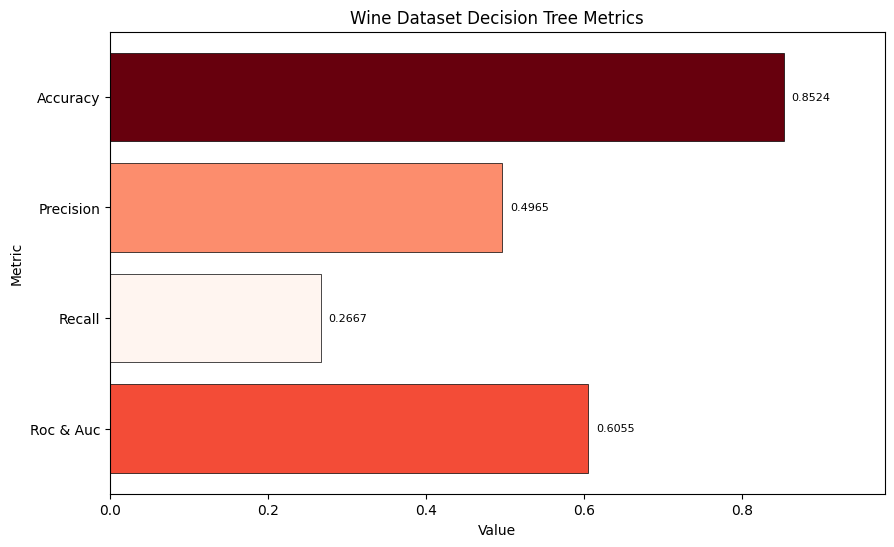

In [13]:
tree_classifier = DecisionTreeClassifier(random_state=1, **best_tree_params)
algorithm_name = "Decision Tree"
tree_metrics, confusion_mat = fit_and_get_metrics(
    model=tree_classifier,
    algorithm=algorithm_name,
    X=X_wine_normalized,
    Y=y_wine,
    n_folds=5,
)
plot_barplot_model_metrics(
    metrics=tree_metrics,
    algorithm=algorithm_name,
    title="Wine Dataset Decision Tree Metrics",
    color=plt.cm.Reds,
)

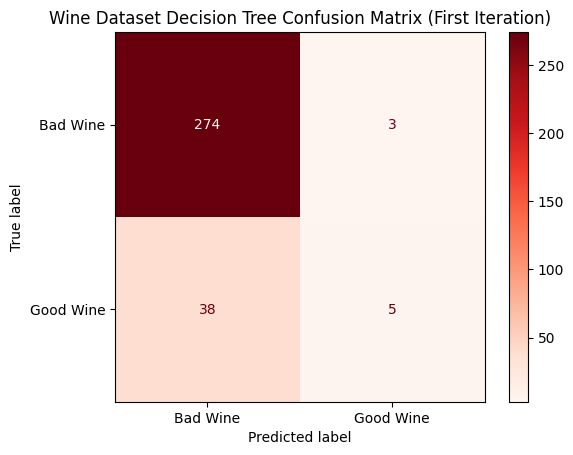

In [14]:
plot_confusion_matrix(
    confusion_matrix=confusion_mat,
    labels=["Bad Wine", "Good Wine"],
    title="Wine Dataset Decision Tree Confusion Matrix (First Iteration)",
    colors=plt.cm.Reds,
)

## KNN

In [15]:
knn_search_space = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    "p": [1, 2],
}

knn_classifier = KNeighborsClassifier()

best_knn_score, best_knn_params, results_knn = make_grid_search(
    model=knn_classifier, search_space=knn_search_space, X=X_wine_normalized, Y=y_wine
)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [16]:
print("Tuned hyperparameters (best parameters): ", best_knn_params)
print("Best score :", best_knn_score)

Tuned hyperparameters (best parameters):  {'algorithm': 'ball_tree', 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
Best score : 0.8255774270724826


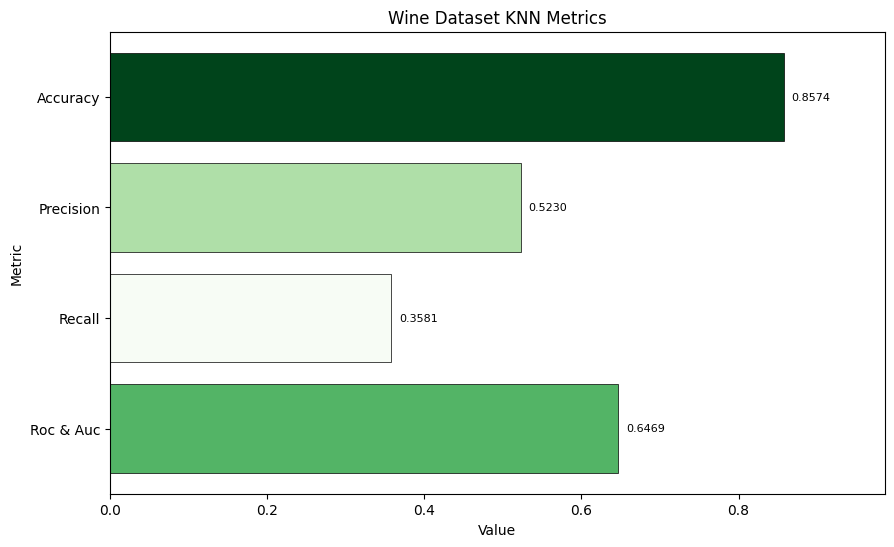

In [17]:
knn_classifier = KNeighborsClassifier(**best_knn_params)
algorithm_name = "Knn"
knn_metrics, confusion_mat = fit_and_get_metrics(
    model=knn_classifier,
    algorithm=algorithm_name,
    X=X_wine_normalized,
    Y=y_wine,
    n_folds=5,
)
plot_barplot_model_metrics(
    metrics=knn_metrics,
    algorithm=algorithm_name,
    title="Wine Dataset KNN Metrics",
    color=plt.cm.Greens,
)

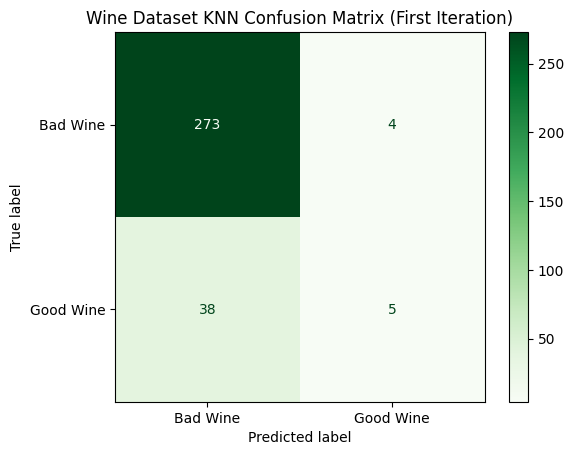

In [18]:
plot_confusion_matrix(
    confusion_matrix=confusion_mat,
    labels=["Bad Wine", "Good Wine"],
    title="Wine Dataset KNN Confusion Matrix (First Iteration)",
    colors=plt.cm.Greens,
)

## Neural Network

In [19]:
# Parameters selection
search_space_mlp = {
    "activation": ["logistic", "tanh", "relu"],
    "solver": ["sgd", "adams"],
    "learning_rate": ["constant", "adaptive"],
    "early_stopping": [True, False],
}

mlp_classifier = MLPClassifier(random_state=1)
best_mlp_score, best_mlp_params, mlp_results = make_grid_search(
    model=mlp_classifier, search_space=search_space_mlp, X=X_wine_normalized, Y=y_wine
)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [20]:
print("Tuned hyperparameters (best parameters): ", best_mlp_params)
print("Best score :", best_mlp_score)

Tuned hyperparameters (best parameters):  {'activation': 'tanh', 'early_stopping': False, 'learning_rate': 'adaptive', 'solver': 'sgd'}
Best score : 0.8762518446263012


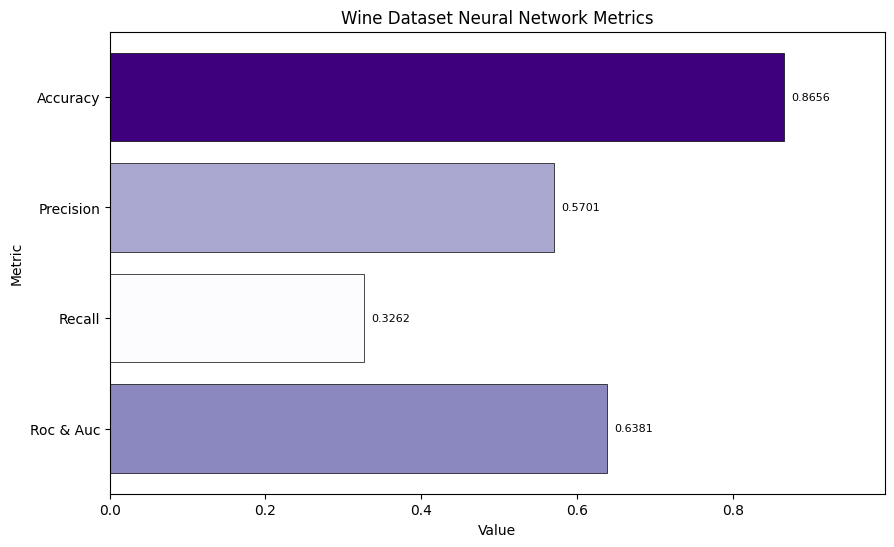

In [21]:
mlp_classifier = MLPClassifier(random_state=1, **best_mlp_params)
algorithm_name = "Neural Network"
mlp_metrics, confusion_mat = fit_and_get_metrics(
    model=mlp_classifier,
    algorithm=algorithm_name,
    X=X_wine_normalized,
    Y=y_wine,
    n_folds=5,
)
plot_barplot_model_metrics(
    metrics=mlp_metrics,
    algorithm=algorithm_name,
    title="Wine Dataset Neural Network Metrics",
    color=plt.cm.Purples,
)

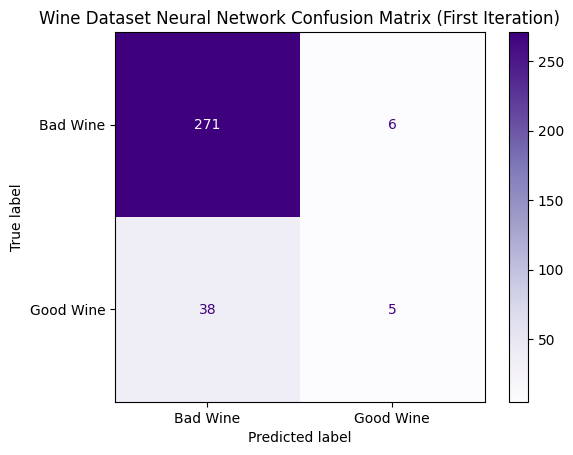

In [22]:
plot_confusion_matrix(
    confusion_matrix=confusion_mat,
    labels=["Bad Wine", "Good Wine"],
    title="Wine Dataset Neural Network Confusion Matrix (First Iteration)",
    colors=plt.cm.Purples,
)

## General

In [23]:
algorithms_metrics = [log_metrics, knn_metrics, tree_metrics, mlp_metrics]
general_metrics = get_general_metrics(algorithms_metrics)
general_metrics.T

,Accuracy,Precision,Recall,Roc & Auc
Logistic Regression,0.868047,0.593194,0.349049,0.649199
Knn,0.857418,0.523044,0.358140,0.646855
Decision Tree,0.852426,0.496485,0.266702,0.605492
Neural Network,0.865553,0.570058,0.326216,0.638143


<Figure size 1000x600 with 0 Axes>

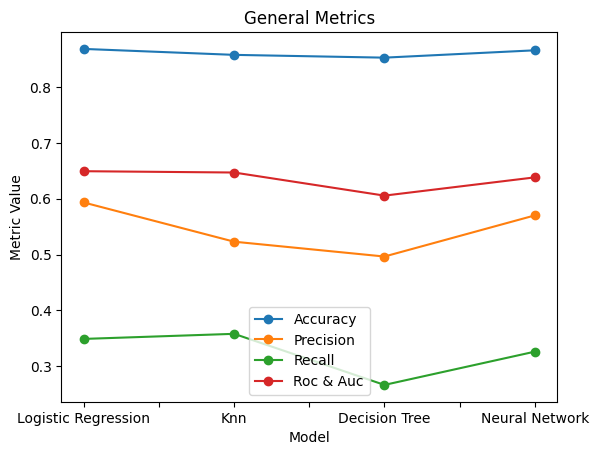

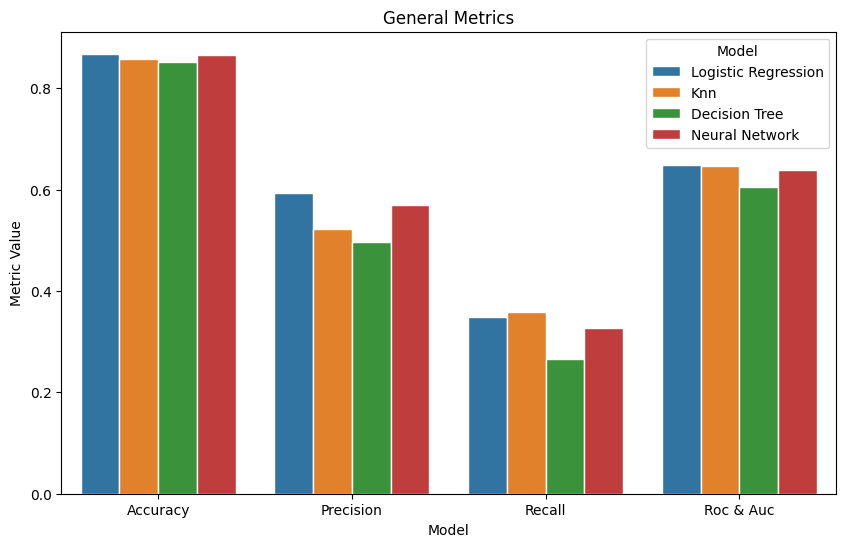

In [24]:
plot_line_models_metrics(general_metrics=general_metrics)
plot_barplot_models_metrics(general_metrics=general_metrics)

# Credit Card Dataset

## Dataset Preparation

In [25]:
# Read dataset
credit_card_data = pd.read_csv("datasets/credit_card_approvals.csv")

In [26]:
credit_card_data.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,1,30.83,0.000,1,1,Industrials,White,1.25,1,1,1,0,ByBirth,202,0,1
1,0,58.67,4.460,1,1,Materials,Black,3.04,1,1,6,0,ByBirth,43,560,1
2,0,24.50,0.500,1,1,Materials,Black,1.50,1,0,0,0,ByBirth,280,824,1
3,1,27.83,1.540,1,1,Industrials,White,3.75,1,1,5,1,ByBirth,100,3,1
4,1,20.17,5.625,1,1,Industrials,White,1.71,1,0,0,0,ByOtherMeans,120,0,1


In [27]:
credit_card_data.describe()
num_columns = credit_card_data.select_dtypes(
    include=["float64", "int64"]
).columns.tolist()
credit_card_data[num_columns].corr()

,Gender,Age,Debt,Married,BankCustomer,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,ZipCode,Income,Approved
Gender,1.000000,0.035044,-0.041746,-0.068062,-0.071250,0.086544,-0.026047,-0.077784,-0.024630,0.051674,0.086007,-0.002063,-0.028934
Age,0.035044,1.000000,0.202177,0.106929,0.099477,0.391464,0.204434,0.086037,0.187327,0.053599,-0.078690,0.018719,0.164086
Debt,-0.041746,0.202177,1.000000,0.074649,0.083781,0.298902,0.244317,0.174846,0.271207,-0.013023,-0.217903,0.123121,0.206294
Married,-0.068062,0.106929,0.074649,1.000000,0.992033,0.069945,0.145073,0.175428,0.113968,-0.009784,-0.017074,-0.006899,0.180583
BankCustomer,-0.071250,0.099477,0.083781,0.992033,1.000000,0.075905,0.138535,0.170268,0.111077,-0.002402,-0.009513,0.057273,0.188964
YearsEmployed,0.086544,0.391464,0.298902,0.069945,0.075905,1.000000,0.345689,0.222982,0.322330,0.138139,-0.070495,0.051345,0.322475
PriorDefault,-0.026047,0.204434,0.244317,0.145073,0.138535,0.345689,1.000000,0.432032,0.379532,0.091276,-0.055010,0.090012,0.720407
Employed,-0.077784,0.086037,0.174846,0.175428,0.170268,0.222982,0.432032,1.000000,0.571498,0.017043,-0.044834,0.077652,0.458301
CreditScore,-0.024630,0.187327,0.271207,0.113968,0.111077,0.322330,0.379532,0.571498,1.000000,0.006944,-0.112816,0.063692,0.406410
DriversLicense,0.051674,0.053599,-0.013023,-0.009784,-0.002402,0.138139,0.091276,0.017043,0.006944,1.000000,0.154924,0.019201,0.031625


In [28]:
# Remove empty rows
credit_card_data.dropna(axis=0, subset=["Approved"], inplace=True)

# Separate data
y_credit = credit_card_data["Approved"]
X_credit = credit_card_data.drop(columns=["Approved"])

# Get categorical and numerical columns
cat_cols = X_credit.select_dtypes(include="object").columns.tolist()
num_cols = X_credit.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Normalize numerical values and transformm categorical ones
pipeline = ColumnTransformer(
    [
        ("numerical", StandardScaler(), num_cols),
        ("categorical_ordinal", OrdinalEncoder(), cat_cols),
    ]
)

X_credit_normalized = pd.DataFrame(pipeline.fit_transform(X_credit))
X_credit_normalized.columns = num_cols + cat_cols

# normalize the values of the cat transform so that thei are from -1 to 1, best for model learning algorithms
cat_pipeline = ColumnTransformer(
    [("categorical_minmax", MinMaxScaler(feature_range=(-1, 1)), cat_cols)]
)

X_credit_normalized[cat_cols] = cat_pipeline.fit_transform(
    X_credit_normalized[cat_cols]
)
X_credit_normalized

,Gender,Age,Debt,Married,BankCustomer,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,ZipCode,Income,Industry,Ethnicity,Citizen
0,0.661438,-0.057723,-0.956613,0.560612,0.556146,-0.291083,0.954650,1.157144,-0.288101,-0.919195,0.123399,-0.195413,0.076923,1.0,-1.0
1,-1.511858,2.291317,-0.060051,0.560612,0.556146,0.244190,0.954650,1.157144,0.740830,-0.919195,-0.791213,-0.087852,0.384615,-0.5,-1.0
2,-1.511858,-0.591826,-0.856102,0.560612,0.556146,-0.216324,0.954650,-0.864196,-0.493887,-0.919195,0.572076,-0.037144,0.384615,-0.5,-1.0
3,0.661438,-0.310853,-0.647038,0.560612,0.556146,0.456505,0.954650,1.157144,0.535044,1.087908,-0.463333,-0.194837,0.076923,1.0,-1.0
4,0.661438,-0.957176,0.174141,0.560612,0.556146,-0.153526,0.954650,-0.864196,-0.493887,-0.919195,-0.348288,-0.195413,0.076923,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,0.661438,-0.880394,1.070704,-1.783765,-1.798090,-0.291083,-1.047504,-0.864196,-0.493887,-0.919195,0.457031,-0.195413,-0.538462,-0.5,-1.0
686,-1.511858,-0.746235,-0.805846,0.560612,0.556146,-0.066806,-1.047504,1.157144,-0.082314,1.087908,0.111894,-0.119736,-0.384615,1.0,-1.0
687,-1.511858,-0.528544,1.757198,-1.783765,-1.798090,-0.066806,-1.047504,1.157144,-0.288101,1.087908,0.111894,-0.195221,-0.076923,0.0,-1.0
688,0.661438,-1.147023,-0.915403,0.560612,0.556146,-0.652915,-1.047504,-0.864196,-0.493887,-0.919195,0.572076,-0.051358,-0.692308,1.0,-1.0


## Logistic Regression

In [29]:
search_space_log = {
    "fit_intercept": [True, False],  # Add bias constant or not
    "solver": ["lbfgs", "liblinear", "newton-cholesky", "newton-cg", "sag", "saga"],
    "max_iter": [1, 5, 10, 30, 50, 100],
}
log_classifier = LogisticRegression(random_state=1)
best_log_score, best_log_params, results_log = make_grid_search(
    model=log_classifier,
    search_space=search_space_log,
    X=X_credit_normalized,
    Y=y_credit,
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [30]:
print("Tuned hyperparameters (best parameters): ", best_log_params)
print("Best score:", best_log_score)

Tuned hyperparameters (best parameters):  {'fit_intercept': False, 'max_iter': 5, 'solver': 'saga'}
Best score: 0.9168171498406128


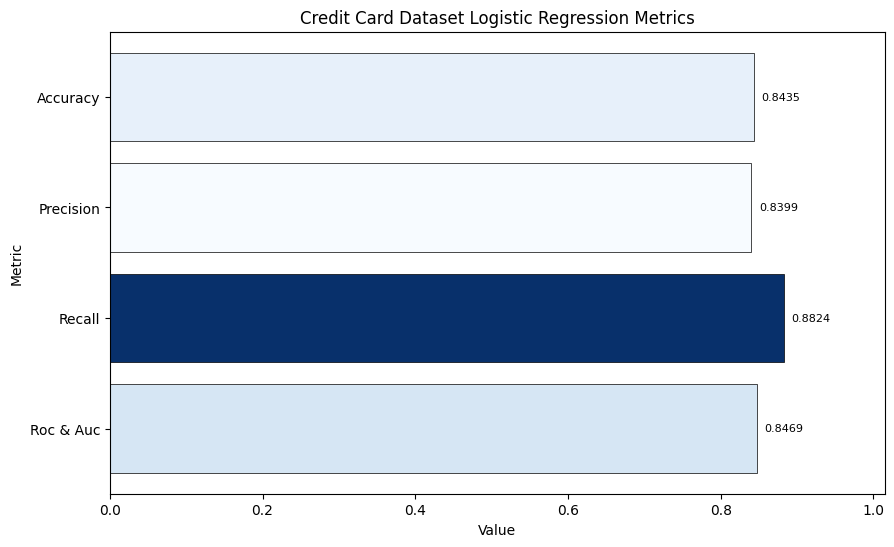

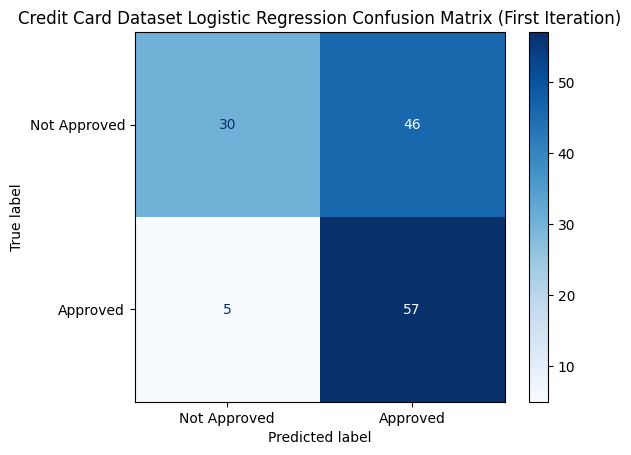

In [31]:
log_classifier = LogisticRegression(random_state=1, **best_log_params)
algorithm_name = "Logistic Regression"
log_metrics, confusion_mat = fit_and_get_metrics(
    model=log_classifier,
    algorithm=algorithm_name,
    X=X_credit_normalized,
    Y=y_credit,
    n_folds=5,
)
plot_barplot_model_metrics(
    metrics=log_metrics,
    algorithm=algorithm_name,
    title="Credit Card Dataset Logistic Regression Metrics",
    color=plt.cm.Blues,
)
plot_confusion_matrix(
    confusion_matrix=confusion_mat,
    labels=["Not Approved", "Approved"],
    title="Credit Card Dataset Logistic Regression Confusion Matrix (First Iteration)",
    colors=plt.cm.Blues,
)

## Decision Trees

In [32]:
# Parameters selection
search_space_tree = {
    "criterion": ["gini", "entropy", "log_loss"],  # Loss criteria
    "splitter": ["best", "random"],  # Type of split for the nodes
    "max_depth": [1, 5, 10, 30, 50, 100],  # Maxiumun tree depth
    "min_samples_split": [
        2,
        5,
        10,
    ],  # Minimun number of samples needed to split a node
}

tree_classifier = DecisionTreeClassifier(random_state=1)
best_tree_score, best_tree_params, tree_results = make_grid_search(
    model=tree_classifier,
    search_space=search_space_tree,
    X=X_credit_normalized,
    Y=y_credit,
)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [33]:
print("Tuned hyperparameters (best parameters): ", best_tree_params)
print("Best score :", best_tree_score)

Tuned hyperparameters (best parameters):  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10, 'splitter': 'random'}
Best score : 0.9050278091748771


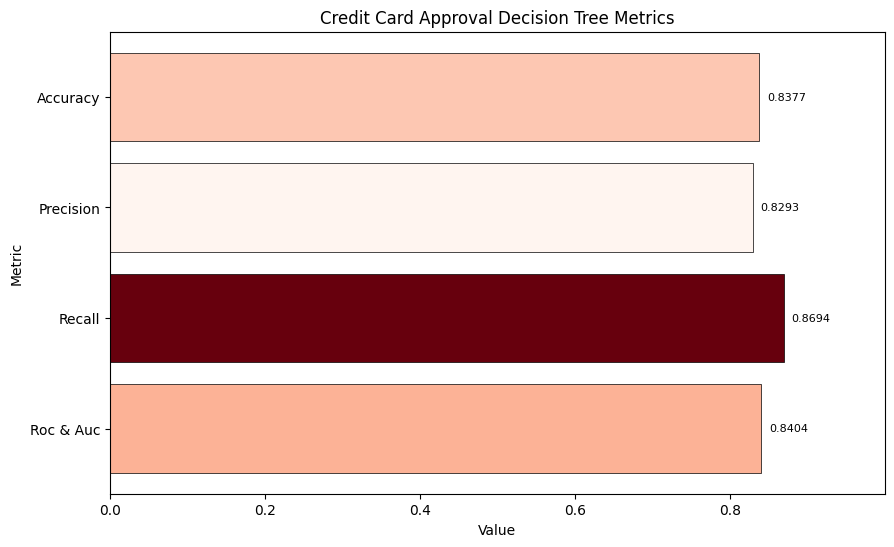

In [34]:
tree_classifier = DecisionTreeClassifier(random_state=1, **best_tree_params)
algorithm_name = "Decision Tree"
tree_metrics, confusion_mat = fit_and_get_metrics(
    model=tree_classifier,
    algorithm="Decision Tree",
    X=X_credit_normalized,
    Y=y_credit,
    n_folds=5,
)
plot_barplot_model_metrics(
    metrics=tree_metrics,
    algorithm=algorithm_name,
    title="Credit Card Approval Decision Tree Metrics",
    color=plt.cm.Reds,
)

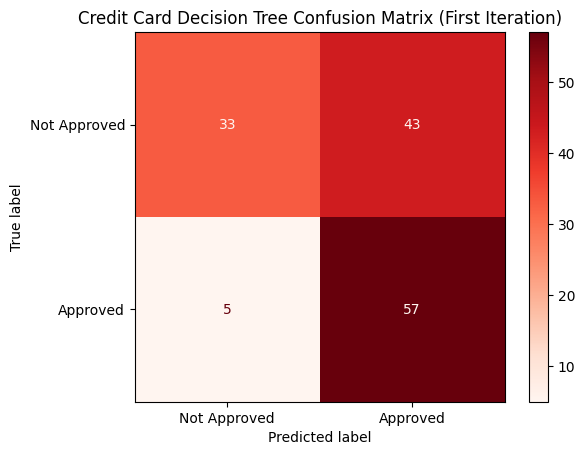

In [35]:
plot_confusion_matrix(
    confusion_matrix=confusion_mat,
    labels=["Not Approved", "Approved"],
    title="Credit Card Decision Tree Confusion Matrix (First Iteration)",
    colors=plt.cm.Reds,
)

## KNN

In [36]:
search_space_knn = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    "p": [1, 2],
}

knn_classifier = KNeighborsClassifier()
best_knn_score, best_knn_params, results_knn = make_grid_search(
    model=knn_classifier,
    search_space=search_space_knn,
    X=X_credit_normalized,
    Y=y_credit,
)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [37]:
print("Tuned hyperparameters (best parameters): ", best_knn_params)
print("Best score :", best_knn_score)

Tuned hyperparameters (best parameters):  {'algorithm': 'ball_tree', 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
Best score : 0.9011271643967378


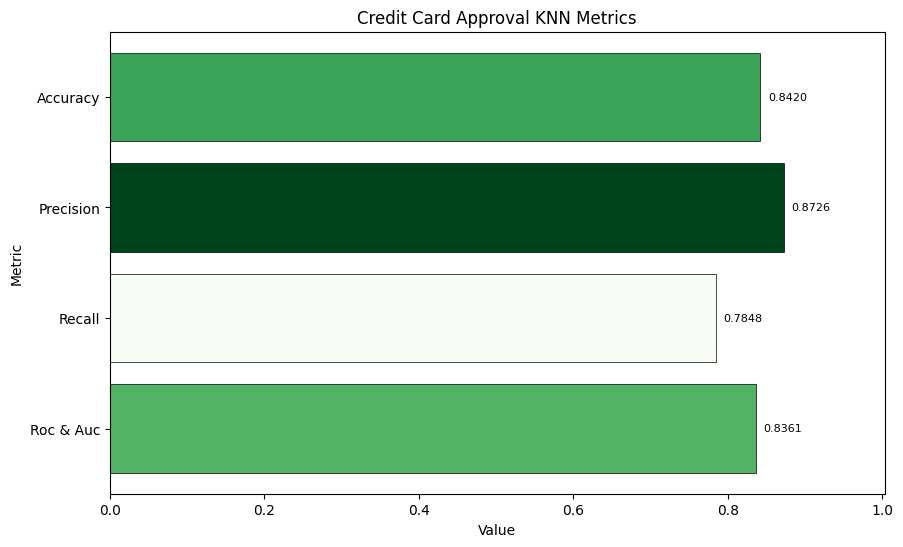

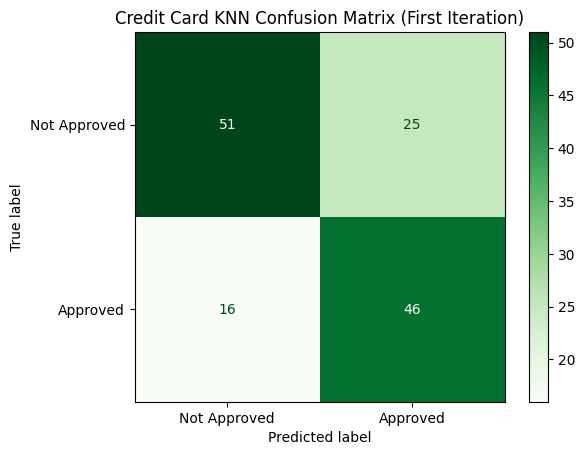

In [38]:
knn_classifier = KNeighborsClassifier(**best_knn_params)
algorithm_name = "Knn"
knn_metrics, confusion_mat = fit_and_get_metrics(
    model=knn_classifier,
    algorithm=algorithm_name,
    X=X_credit_normalized,
    Y=y_credit,
    n_folds=5,
)
plot_barplot_model_metrics(
    metrics=knn_metrics,
    algorithm=algorithm_name,
    title="Credit Card Approval KNN Metrics",
    color=plt.cm.Greens,
)
plot_confusion_matrix(
    confusion_matrix=confusion_mat,
    labels=["Not Approved", "Approved"],
    title="Credit Card KNN Confusion Matrix (First Iteration)",
    colors=plt.cm.Greens,
)

## Neural Network

In [39]:
# Parameters selection
search_space_mlp = {
    "activation": ["logistic", "tanh", "relu"],
    "solver": ["sgd", "adams"],
    "learning_rate": ["constant", "adaptive"],
    "early_stopping": [True, False],
}

mlp_classifier = MLPClassifier(random_state=1)
best_mlp_score, best_mlp_params, mlp_results = make_grid_search(
    model=mlp_classifier,
    search_space=search_space_mlp,
    X=X_credit_normalized,
    Y=y_credit,
)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [40]:
print("Tuned hyperparameters (best parameters): ", best_mlp_params)
print("Best score :", best_mlp_score)

Tuned hyperparameters (best parameters):  {'activation': 'tanh', 'early_stopping': False, 'learning_rate': 'constant', 'solver': 'sgd'}
Best score : 0.9120096344413747


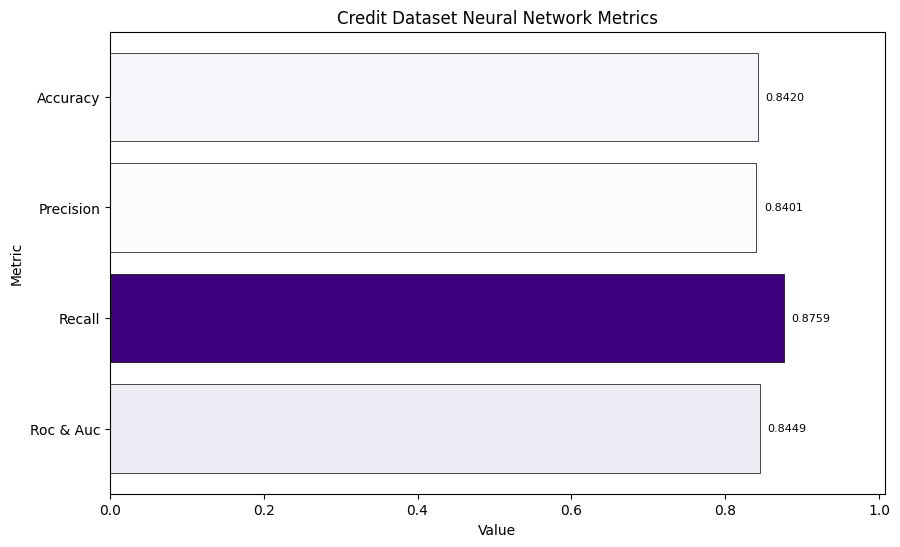

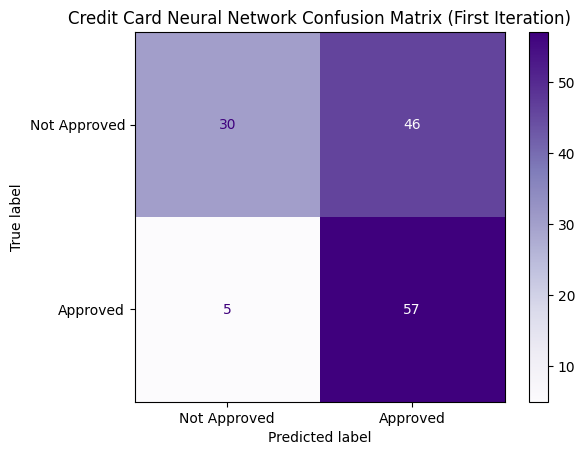

In [41]:
mlp_classifier = MLPClassifier(random_state=1, **best_mlp_params)
algorithm_name = "Neural Network"
mlp_metrics, confusion_mat = fit_and_get_metrics(
    model=mlp_classifier,
    algorithm=algorithm_name,
    X=X_credit_normalized,
    Y=y_credit,
    n_folds=5,
)
plot_barplot_model_metrics(
    metrics=mlp_metrics,
    algorithm=algorithm_name,
    title="Credit Dataset Neural Network Metrics",
    color=plt.cm.Purples,
)
plot_confusion_matrix(
    confusion_matrix=confusion_mat,
    labels=["Not Approved", "Approved"],
    title="Credit Card Neural Network Confusion Matrix (First Iteration)",
    colors=plt.cm.Purples,
)

## General

In [42]:
algorithms_metrics = [log_metrics, knn_metrics, tree_metrics, mlp_metrics]
general_metrics = get_general_metrics(algorithms_metrics)
general_metrics.T

,Accuracy,Precision,Recall,Roc & Auc
Logistic Regression,0.843478,0.839850,0.882443,0.846895
Knn,0.842029,0.872583,0.784770,0.836097
Decision Tree,0.837681,0.829255,0.869434,0.840425
Neural Network,0.842029,0.840135,0.875886,0.844932


<Figure size 1000x600 with 0 Axes>

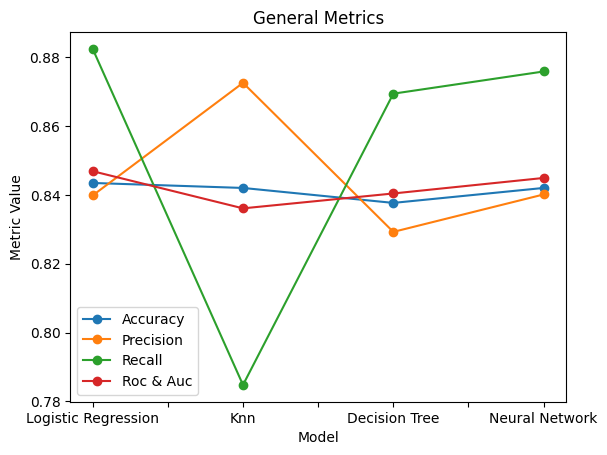

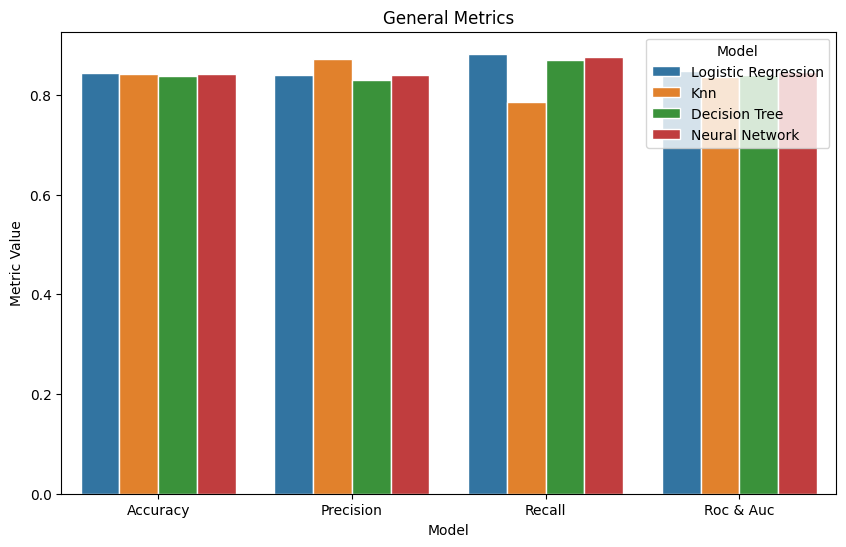

In [43]:
plot_line_models_metrics(general_metrics=general_metrics)
plot_barplot_models_metrics(general_metrics=general_metrics)